## Online Sparsification

This notebook performs three task:

1. Linear systems solve using APPR
2. Online node learning with online sparsification 
3. Clustering

Additionally,  **sparsification is performed online**, meaning that the reductions in graph connectivity happen dynamically during the algorithms.




---

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix, lil_matrix

from data_loader import *
from sparsify import *
from appr import *
from RelaxRegularizeAPPR import *
from clustering import *

Text(0.5, 1.0, 'Original: political-blog adjacency')

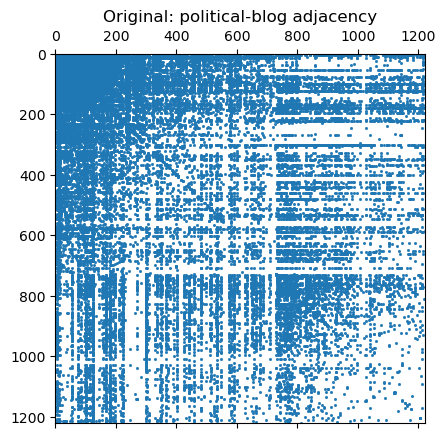

In [2]:
# load test graph
dataset = 'political-blog'
adj_matrix, labels = load_graph_data(dataset)

# compute Laplacian, normalized laplacian, and one-hot embedding of labels
Theta, nTheta, Y_onehot =  prepare_problems(adj_matrix,labels) 

# visualize
plt.spy(adj_matrix, markersize=1)
plt.title('Original: %s adjacency' % dataset)

In [3]:
#stats about unsparsified graph
n = len(labels)
num_classes = max(labels)+1
degree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()

In [4]:
# We will sparsify so that the c = max degree of the new graph is 2 x the median degree of the original graph.
# To compare, for uniform and resistive sampling we will use the corresponding p = percentage of nodes retained.

c = int(np.median(degree_vector)*2)
p = np.sum(degree_vector[degree_vector < c] / np.sum(degree_vector))
print(c,p)

26 0.1904519757111663


## APPR for linear solve

This section explores how APPR can be used to solve linear systems.

In [5]:
#Now, we will solve a linear system, using APPR, on the original and subsampled graph. 


epsilon = 1e-3
y = np.random.randn(n) # random right hand side


sampling = 'stoch_unif'
de_bias = False
de_bias_period = 10

beta = 0.1 
alpha = 1 - 2*beta
res = 0.
x = np.zeros(n)
for s in range(n):
    xs,r = appr(adj_matrix,degree_vector, sampling = sampling,  maxneighbors = c,
                epsilon = epsilon, alpha= alpha, s = s,maxiter = 100,  seed = 42,
                de_bias = de_bias, de_bias_period = de_bias_period, max_neighbors_debias = c*10, 
                merge_weight=1 )
    x = x + y[s]*xs
    res += np.linalg.norm(r)
print('Residual norm for APPR: %e' % res)
    

# Now run the original unsparsified system
x_orig = np.zeros(n)
for s in range(n):
    xs,r = appr(adj_matrix,degree_vector, sampling = sampling,  maxneighbors = None,
                epsilon = epsilon, alpha= alpha, s = s,maxiter = 100,  seed = 42,
                de_bias = de_bias, de_bias_period = de_bias_period, max_neighbors_debias = c*10, 
                merge_weight=1 )
    x_orig = x_orig + y[s]*xs
    
print('Difference with original adj.: %e' % np.linalg.norm(x-x_orig))

# compare against direct solve
x_true,_ = ppr_solve(adj_matrix, degree_vector,alpha=1 - 2*beta,y=y)
print('Difference with true x.: %e' % np.linalg.norm(x-x_true))



Residual norm for APPR: 4.881081e+01
Difference with original adj.: 3.131182e-02
Difference with true x.: 1.376209e+00


## Online node labeling via regularization method (Belkin et al)

 Note that even when subsampling has large error in linear solve, it can have good performance in a downstream task, like node labeling.

In [6]:
# compute smoothness term

beta = 0.9 
epsilon = 1e-3
T= beta * nTheta + (1. - beta) * np.eye(n)
sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()
de_bias_period = 10
sampling = 'stoch_unif'

#without sparsification

out = Regularize_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma,  Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate without sparsification: %e' % misclass)

# with sparsification
out = Regularize_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma,  Y_onehot, seed = 42,
                maxneighbors = c, maxiter = 100, sampling = sampling,
                de_bias = False, de_bias_period = 0, 
                max_neighbors_debias = 0, merge_weight = 1)
 

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification: %e' % misclass)



# with sparsification
out = Regularize_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma,  Y_onehot, seed = 42,
                maxneighbors = c, maxiter = 100, sampling = sampling,
                de_bias = True, de_bias_period = de_bias_period, 
                max_neighbors_debias = c*10, merge_weight = 1)
 

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification and debiasing: %e' % misclass)



100%|██████████| 1222/1222 [00:02<00:00, 597.23it/s]


Misclassification rate without sparsification: 2.381342e-01


100%|██████████| 1222/1222 [00:02<00:00, 533.34it/s]


Misclassification rate with sparsification: 2.242226e-01


100%|██████████| 1222/1222 [00:02<00:00, 539.82it/s]

Misclassification rate with sparsification and debiasing: 2.250409e-01


## Online node labeling via relaxation method (Rakhlin et al)

In [7]:
# compute smoothness term

beta = 0.9 
epsilon = 1e-3
T= beta * nTheta + (1. - beta) * np.eye(n)
sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()
de_bias_period = 10
sampling = 'stoch_unif'
Delta = num_classes

#without sparsification

out = Relaxation_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma, Delta, Y_onehot, seed = 42,
                maxneighbors = None, maxiter = 100)

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate without sparsification: %e' % misclass)

# with sparsification
out = Relaxation_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma,  Delta, Y_onehot, seed = 42,
                maxneighbors = c, maxiter = 100, sampling = sampling,
                de_bias = False, de_bias_period = 0, 
                max_neighbors_debias = 0, merge_weight = 1)
 

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification: %e' % misclass)



# with sparsification
out = Relaxation_APPR(adj_matrix,degree_vector,
                epsilon, beta, sigma, Delta,  Y_onehot, seed = 42,
                maxneighbors = c, maxiter = 100, sampling = sampling,
                de_bias = True, de_bias_period = de_bias_period, 
                max_neighbors_debias = c*10, merge_weight = 1)
 

Y_pred = out['y_pred']
Y_pred_soft = out['q']
misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))

print('Misclassification rate with sparsification and debiasing: %e' % misclass)

 



100%|██████████| 1222/1222 [00:02<00:00, 564.49it/s]


Misclassification rate without sparsification: 2.585925e-01


100%|██████████| 1222/1222 [00:02<00:00, 516.42it/s]


Misclassification rate with sparsification: 2.561375e-01


100%|██████████| 1222/1222 [00:02<00:00, 533.25it/s]

Misclassification rate with sparsification and debiasing: 2.577741e-01


## Clustering via subsampled approximate PPR

In [8]:

beta = 0.4 
alpha = 1 - 2*beta
num_clusters = num_classes*10
epsilon = 1e-4

de_bias_period = 10
sampling = 'stoch_unif'

cluster_map = get_cluster_map(adj_matrix, degree_vector, epsilon, alpha, None, n,False,0,n)
seeds = get_popular_seeds(cluster_map,num_clusters)
score,  cluster_assign = cluster_ppr(cluster_map,seeds, labels,num_clusters)
print('Cluster score, no sparsification: %e' % score)

cluster_map = get_cluster_map(adj_matrix,degree_vector, epsilon, alpha, sampling, c,False,0,c*10)
seeds = get_popular_seeds(cluster_map,num_clusters)
score,  cluster_assign = cluster_ppr(cluster_map,seeds, labels,num_clusters)
print('Cluster score, with sparsification: %e' % score)

cluster_map = get_cluster_map(adj_matrix,degree_vector, epsilon, alpha, sampling, c,True,de_bias_period,c*10)
seeds = get_popular_seeds(cluster_map,num_clusters)
score,  cluster_assign = cluster_ppr(cluster_map,seeds, labels,num_clusters)
print('Cluster score, with sparsification and debiasing: %e' % score)

100%|██████████| 1222/1222 [00:19<00:00, 62.38it/s]


[ 5  0  2 ...  7 17 -1]
Cluster score, no sparsification: 6.538462e-01


100%|██████████| 1222/1222 [00:19<00:00, 61.36it/s]


Cluster score, with sparsification: 5.981997e-01


100%|██████████| 1222/1222 [00:28<00:00, 43.17it/s]

Cluster score, with sparsification and debiasing: 6.088380e-01
